In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [46]:
N_HIDDEN = 8
WIDTH = 12

# 4K
# RESOLUTION_X = 3840
# RESOLUTION_Y = 2160

# 1080p
# RESOLUTION_X = 1920
# RESOLUTION_Y = 1080

RESOLUTION_X = 1920
RESOLUTION_Y = 1080

In [47]:
def getLinear(in_dims, out_dims):
    layer = torch.nn.Linear(in_dims, out_dims)
    torch.nn.init.uniform_(layer.weight, -2.0, 2.0)
    return layer

In [48]:
def getModel():
    layers = [
        getLinear(5, WIDTH),
        torch.nn.Tanh()
    ]

    for i in range(N_HIDDEN):
        layers.append(getLinear(WIDTH, WIDTH))
        layers.append(torch.nn.Tanh())

    layers.append(getLinear(WIDTH, 3))
    layers.append(torch.nn.Sigmoid())

    model = torch.nn.Sequential(*layers)
    model = model.to(device)
    
    return model

In [49]:
img = np.array(Image.open('/home/aidan/skyline.jpg')).astype(np.float32)
img -= img.min()
img /= img.max()
img = (img * 2) - 1

print(img.shape)
img = img[:, :, :3]

(1080, 1920, 3)


(-0.5, 1919.5, 1079.5, -0.5)

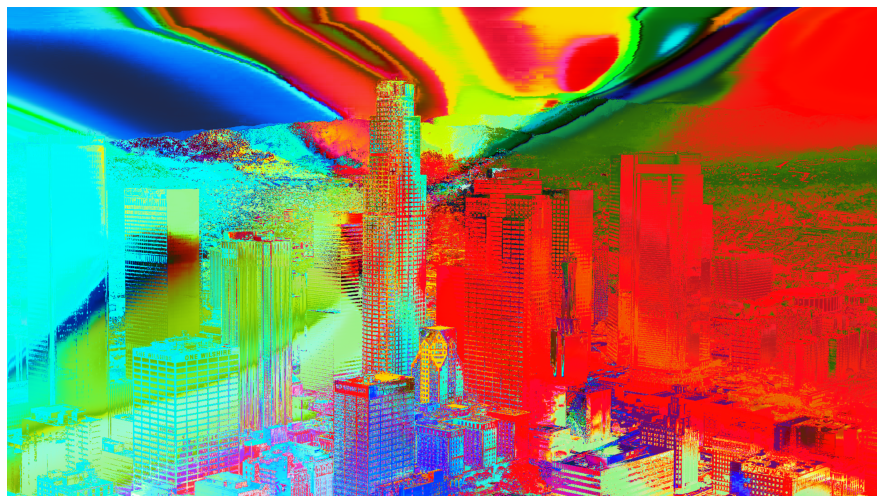

In [50]:
device = torch.device('cuda')

model = getModel()

coords_x = np.linspace(start=-1, stop=1, num=RESOLUTION_X, dtype=np.float32)
coords_y = np.linspace(start=-1, stop=1, num=RESOLUTION_Y, dtype=np.float32)

coords = np.stack(np.meshgrid(coords_x, coords_y))
coords = np.transpose(coords, [1, 2, 0])
coords = np.concatenate([coords, img], axis=2)

# Change scale of channels
coords[:, :, :2] *= 1.0 # x, y channels
coords[:, :, 2:] *= 0.2 # image channels

coords_flat = coords.reshape(-1, 5)
coords_flat = torch.tensor(coords_flat).to(torch.float)
coords_flat = coords_flat.to(device)

with torch.no_grad():
    out_flat = model(coords_flat)
    
out = out_flat.to('cpu').numpy().reshape(RESOLUTION_Y, RESOLUTION_X, 3)

# out = np.rot90(out, k=3)
plt.subplots(figsize=(16, 9))
plt.imshow(out)
plt.axis('off')

In [41]:
plt.imsave(fname='some_out.png', arr=out, format='png')